<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#$\tau-$leap-simulation" data-toc-modified-id="$\tau-$leap-simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>$\tau-$leap simulation</a></span></li></ul></div>

In [2]:
using Distributions
using StatsBase, SpecialFunctions
using Plots
import PyPlot
const plt = PyPlot
using DifferentialEquations

function LV_determistic(du,u,p,t)
    JB, mB, B0, JV, mV, V0 = p
    du[1] = u[1]*(1 - u[2]/V0 )*JB
    du[2] = u[2]*(u[1]/B0 - 1) *JV
end

function sample_poisson(rate)
    # sample a poisson distribution
    return rand(Poisson(rate))
end


sample_poisson (generic function with 1 method)

# $\tau-$leap simulation

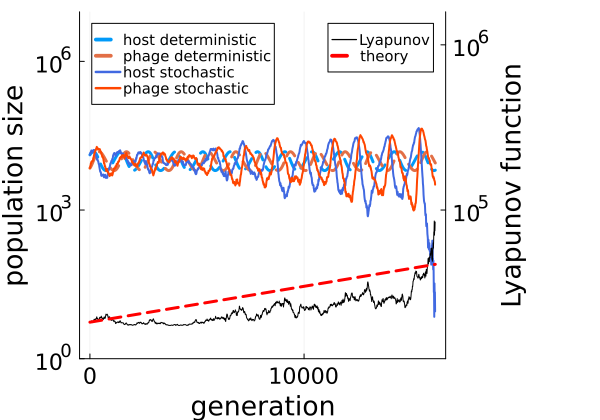

In [41]:
L = 40
s = 0.005
N = 10^6
r = 0
K = L*(L-1)/2
m = N*r/K
δt= 1
Navg = 10^4
JB, mB, B0 = J, m, Navg
JV, mV, V0 = J, m, Navg
pars = [JB, mB, B0, JV, mV, V0];
N0 = [1.3*Navg, 0.7*Navg]

function simulate_poisson(n, pars; tmax=100, δt=1)
    sB, mB, B0, sV, mV, V0 = pars
    # Will store the time of events
    t = [0.0]
    # Will store the number of individuals
    events = [[1, 1], [1, -1], [2, 1], [2, -1]]
    count = 1
    B, V = n[1], n[2]
    Bt, Vt = [B], [V]
    t_seed = 0
    t_est = 0
    passboundary_flag = false
    while (last(t) < tmax)
        if B>0
            fitB = sB*(1 - V/V0) 
        else
            fitB = -10000
        end
        
        if V>0
            fitV = sV*(B/B0-1) 
        else
            fitV= -10000
        end

        B = maximum([sample_poisson(B*exp(fitB*δt))+ sample_poisson(mB*δt)- sample_poisson(mB*δt*B/B0),0 ])
   
        V = maximum([sample_poisson(V*exp(fitV*δt)) + sample_poisson(mV*δt)- sample_poisson(mV*δt*V/V0), 0])
  
            
        if count%10^6==0
            println("time "*string(last(t)))
            println(B, "  ", V)
        end
        if length(Vt)>0 && last(Vt)==0 && V>0
            t_seed = last(t)+δt
        end
        
        s = sB
        if V >= 2/s && !passboundary_flag
            t_est = last(t) +δt
            B_est = B
            passboundary_flag = true
        elseif V < 2/s
            passboundary_flag = false
        end
        
        count = count + 1
        push!(Bt, copy(B))
        push!(Vt, copy(V))
        push!(t, last(t)+δt)
        if V==0 || B ==0
            return (t, Bt, Vt, t_est, t_seed)
        end
    end
    return (t, Bt, Vt, t_est, t_seed)
end

p = [JB, mB, B0, JV, mV, V0];

u0 = N0
tmax = 10^8
δt = 1


data = simulate_poisson(N0, pars; tmax=tmax, δt=δt)
T, Bt, Vt = data[1], data[2], data[3]
tspan = (1.0,length(T))
prob = ODEProblem(LV_determistic,u0, tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=1)

E = Bt .+Vt .- B0*log.(Bt/B0) .- V0*log.(Vt/V0)
G = exp.(-Bt./B0 .-Vt./V0).*Bt.*Vt;
t_est, t_seed = data[4], data[5]
s = J/K
t0 = 1 
t1 = floor(Int64, length(T))-1
Δt= 10
Det = Array(sol)
plot()
plot!(1:length(T), [sol[1,:], sol[2,:]], labels=["host deterministic" "phage deterministic"], linestyle=:dash, linewidth=3)
plot!(T[t0:Δt:t1], Bt[t0:Δt:t1], color="royalblue", linewidth=2, label="host stochastic")
plot!(T[t0:Δt:t1], Vt[t0:Δt:t1], color="orangered", linewidth=2,label="phage stochastic")
plot!(xlabel ="generation", ylabel ="population size")
plot!(legend=:topleft)
plot!(yscale=:log, ylims=(10^0, 10^7))
plot!(yticks = (10 .^(0:3:8)))
plot!(tickfontsize=15)
p = twinx()
plot!(p, T[t0:Δt:t1], E[t0:Δt:t1], color="black",  label="Lyapunov")
plot!(p, T, E[1] .* exp.(1/(2*B0) .*T),linewidth = 3, linestyle=:dash,label="theory", color="red", dpi=300)
plot!(p, yscale=:log, ylims=(10^4.1, 10^6.2))
plot!(p, ylabel="Lyapunov function")
#plot!(fig, T[t0:Δt:t1], 2 ./(J.*Bt[t0:Δt:t1] ./N), linewidth = 3, linestyle=:dash,label="established population")
#hline!(fig,[2/s], linestyle=:dash,label="" )
plot!(p, legend=:topright)
plot!(right_margin = 20Plots.mm)
plot!(dpi=300)
plot!(size=(600,420))
plot!(tickfontsize=15, legendfontsize=10,xguidefontsize=18,yguidefontsize=18)
plot!(xticks = (0:10^4:4*10^4))
savefig( "Lyapunov_pair_1trial.png")
plot!()